# RMSX Demonstration

This notebook includes everything you need to run **RMSX** and **Flipbook**. Just run each cell. You are encouraged to try different parameters and use your own trajectories directly within this notebook or by making a copy of it.


We'll cover:

1. Environment setup
2. Loading demo input files
3. Single-chain RMSX
4. Multi-chain RMSX
5. FlipBook snapshots (optional)
6. Interpreting results

> **Note:** Adjust file paths as needed for your machine. We reccomend not editing the first two cells, though.

## 1) Environment Setup

- **R** — used for heatmaps and RMSD/RMSF plots via `Rscript`.
- **ChimeraX** (optional) — used for FlipBook image generation.


### Quick Start

In [5]:
# One-click install for this kernel (no sudo; no Plotly required)
import sys, os, site, tempfile, urllib.request, subprocess, shutil

def _ensure_pip_in_kernel():
    try:
        import pip  # noqa: F401
        return
    except Exception:
        pass
    # Bootstrap pip into THIS kernel if it's missing
    print("Bootstrapping pip into this Jupyter kernel…")
    with tempfile.TemporaryDirectory() as td:
        gp = os.path.join(td, "get-pip.py")
        urllib.request.urlretrieve("https://bootstrap.pypa.io/get-pip.py", gp)
        subprocess.check_call([sys.executable, gp, "--user"])
    # Make sure user-site is importable in this process
    us = site.getusersitepackages()
    if us not in sys.path:
        sys.path.append(us)

_ensure_pip_in_kernel()

# Use Jupyter's %pip so installs target THIS kernel

%pip install -U pip wheel setuptools
%pip install -U "numpy>=1.26,<2.0" "pandas>=2.2,<2.3" "MDAnalysis>=2.6,<3" "scipy>=1.10" "plotly>=5"
%pip install -U "git+https://github.com/AntunesLab/rmsx.git@main" plotly>=5

# Optional: show Rscript (for plots) if available
import subprocess
RSCRIPT = os.environ.get("RSCRIPT", "Rscript")
try:
    out = subprocess.run([RSCRIPT, "-e", "cat(R.version.string)"] , capture_output=True, text=True)
    print(out.stdout or out.stderr or "Rscript OK")
except FileNotFoundError:
    print("⚠️ Rscript not found. Heatmap/RMSD/RMSF plots will be skipped until R is installed or RSCRIPT is set.")


Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 31.8 MB/s  0:00:00 eta 0:00:01
  Attempting uninstall: plotly
    Found existing installation: plotly 6.2.0
    Uninstalling plotly-6.2.0:
      Successfully uninstalled plotly-6.2.0
Note: you may need to restart the kernel to use updated packages.
zsh:1: 5 not found
Note: you may need to restart the kernel to use updated packages.
R version 4.4.0 (2024-04-24)


In [6]:
# Imports & locate sample data
from pathlib import Path
import os, subprocess

from rmsx import run_rmsx, run_rmsx_flipbook, all_chain_rmsx, run_shift_flipbook
import rmsx

pkg_dir = Path(rmsx.__file__).resolve().parent

# Optional: set this to use your own dataset folder
# os.environ["RMSX_TEST_DIR"] = "/path/to/test_files"
env_override = os.environ.get("RMSX_TEST_DIR")

candidates = []
if env_override:
    candidates.append(Path(env_override))

candidates += [
    Path.cwd() / "test_files",              # next to this notebook
    Path.cwd() / "rmsx" / "test_files",     # if you cloned into ./rmsx
    pkg_dir / "test_files",                 # packaged tests (if included)
    pkg_dir.parent / "test_files",          # repo layout when running from source
]

test_dir = next((p for p in candidates if p.exists()), None)

# Last resort: clone repo to fetch sample data (does not affect installed package)
if not test_dir:
    REPO_URL = "https://github.com/AntunesLab/rmsx.git"
    REPO_DIR = Path.cwd() / "rmsx"
    if not REPO_DIR.exists():
        print("Cloning RMSX repo to retrieve sample data…")
        subprocess.check_call(["git", "clone", REPO_URL, str(REPO_DIR)])
    test_dir = REPO_DIR / "test_files"
    if not test_dir.exists():
        raise FileNotFoundError("Couldn't locate test_files after cloning. Please report this issue.")

# Single-chain demo (Ubiquitin)
pdb_file   = (test_dir / "1UBQ.pdb").as_posix()
dcd_file   = (test_dir / "mon_sys.dcd").as_posix()
output_dir = (test_dir / "example_uqb").as_posix()

# Multi-chain demo (protease) — files live directly under test_files/
pdb_file_multi   = (test_dir / "protease_backbone.pdb").as_posix()
traj_file_multi  = (test_dir / "short_protease_backbone.dcd").as_posix()
output_dir_multi = (test_dir / "protease").as_posix()

print("Single-chain inputs:")
print("  PDB:", pdb_file)
print("  DCD:", dcd_file)
print("  out:", output_dir)

print("\nMulti-chain inputs:")
print("  PDB:", pdb_file_multi)
print("  DCD:", traj_file_multi)
print("  out:", output_dir_multi)


Single-chain inputs:
  PDB: /Users/finn/Downloads/rmsx/rmsx/test_files/1UBQ.pdb
  DCD: /Users/finn/Downloads/rmsx/rmsx/test_files/mon_sys.dcd
  out: /Users/finn/Downloads/rmsx/rmsx/test_files/example_uqb

Multi-chain inputs:
  PDB: /Users/finn/Downloads/rmsx/rmsx/test_files/protease_backbone.pdb
  DCD: /Users/finn/Downloads/rmsx/rmsx/test_files/short_protease_backbone.dcd
  out: /Users/finn/Downloads/rmsx/rmsx/test_files/protease


*Windows users: if R isn’t on PATH, set `RSCRIPT` before running:*

In [7]:
import os
!pwd

/Users/finn/Downloads/rmsx/rmsx


## 2) Load Demo Input Files

These come with the package as `test_files`. Rather than editing these we recocomend adding your paths in later cells. 

## 3) Single-Chain RMSX

`run_rmsx` computes per-slice RMSX and generates:
- RMSX heatmap
- RMSD time series
- RMSF per-residue

Edit `palette` and `chain_sele` as needed. (For the included Ubiquitin demo, the chain is `"7"`.)

Python Executable: /Users/finn/Library/r-miniconda-arm64/bin/python
Current Working Directory: /Users/finn/Downloads/rmsx/rmsx
Overwriting existing directory: /Users/finn/Downloads/rmsx/rmsx/test_files/example_uqb/chain_7_rmsx
The directory '/Users/finn/Downloads/rmsx/rmsx/test_files/example_uqb/chain_7_rmsx' is ready for use.
Starting analysis...
Using the slicing method with num_slices=9
Truncating 1 excess frame(s). Original size: 316, Updated: 315
Processing frames 0 to 314 of the trajectory.
Number of slices: 9
First frame of slice 1 written to /Users/finn/Downloads/rmsx/rmsx/test_files/example_uqb/chain_7_rmsx/slice_1_first_frame.pdb
Slice 1: RMSF computed for frames 0 to 34 (35 frames)
First frame of slice 2 written to /Users/finn/Downloads/rmsx/rmsx/test_files/example_uqb/chain_7_rmsx/slice_2_first_frame.pdb
Slice 2: RMSF computed for frames 35 to 69 (35 frames)
First frame of slice 3 written to /Users/finn/Downloads/rmsx/rmsx/test_files/example_uqb/chain_7_rmsx/slice_3_first_f

/Users/finn/Library/r-miniconda-arm64/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


Updated PDB B-factors in /Users/finn/Downloads/rmsx/rmsx/test_files/example_uqb/chain_7_rmsx/slice_6_first_frame.pdb
Updated PDB B-factors in /Users/finn/Downloads/rmsx/rmsx/test_files/example_uqb/chain_7_rmsx/slice_7_first_frame.pdb
Updated PDB B-factors in /Users/finn/Downloads/rmsx/rmsx/test_files/example_uqb/chain_7_rmsx/slice_8_first_frame.pdb
Updated PDB B-factors in /Users/finn/Downloads/rmsx/rmsx/test_files/example_uqb/chain_7_rmsx/slice_9_first_frame.pdb
Generating plots...
Found R script at /Users/finn/Downloads/rmsx/rmsx/rmsx/r_scripts/plot_rmsx.R.
Running R script command:
Rscript /Users/finn/Downloads/rmsx/rmsx/rmsx/r_scripts/plot_rmsx.R /Users/finn/Downloads/rmsx/rmsx/test_files/example_uqb/chain_7_rmsx/rmsx_mon_sys_0.015_ns.csv /Users/finn/Downloads/rmsx/rmsx/test_files/example_uqb/chain_7_rmsx/rmsd.csv /Users/finn/Downloads/rmsx/rmsx/test_files/example_uqb/chain_7_rmsx/rmsf.csv FALSE TRUE mako   FALSE 
R script executed successfully.
R STDOUT:
 # A tibble: 1 × 2
  Chain

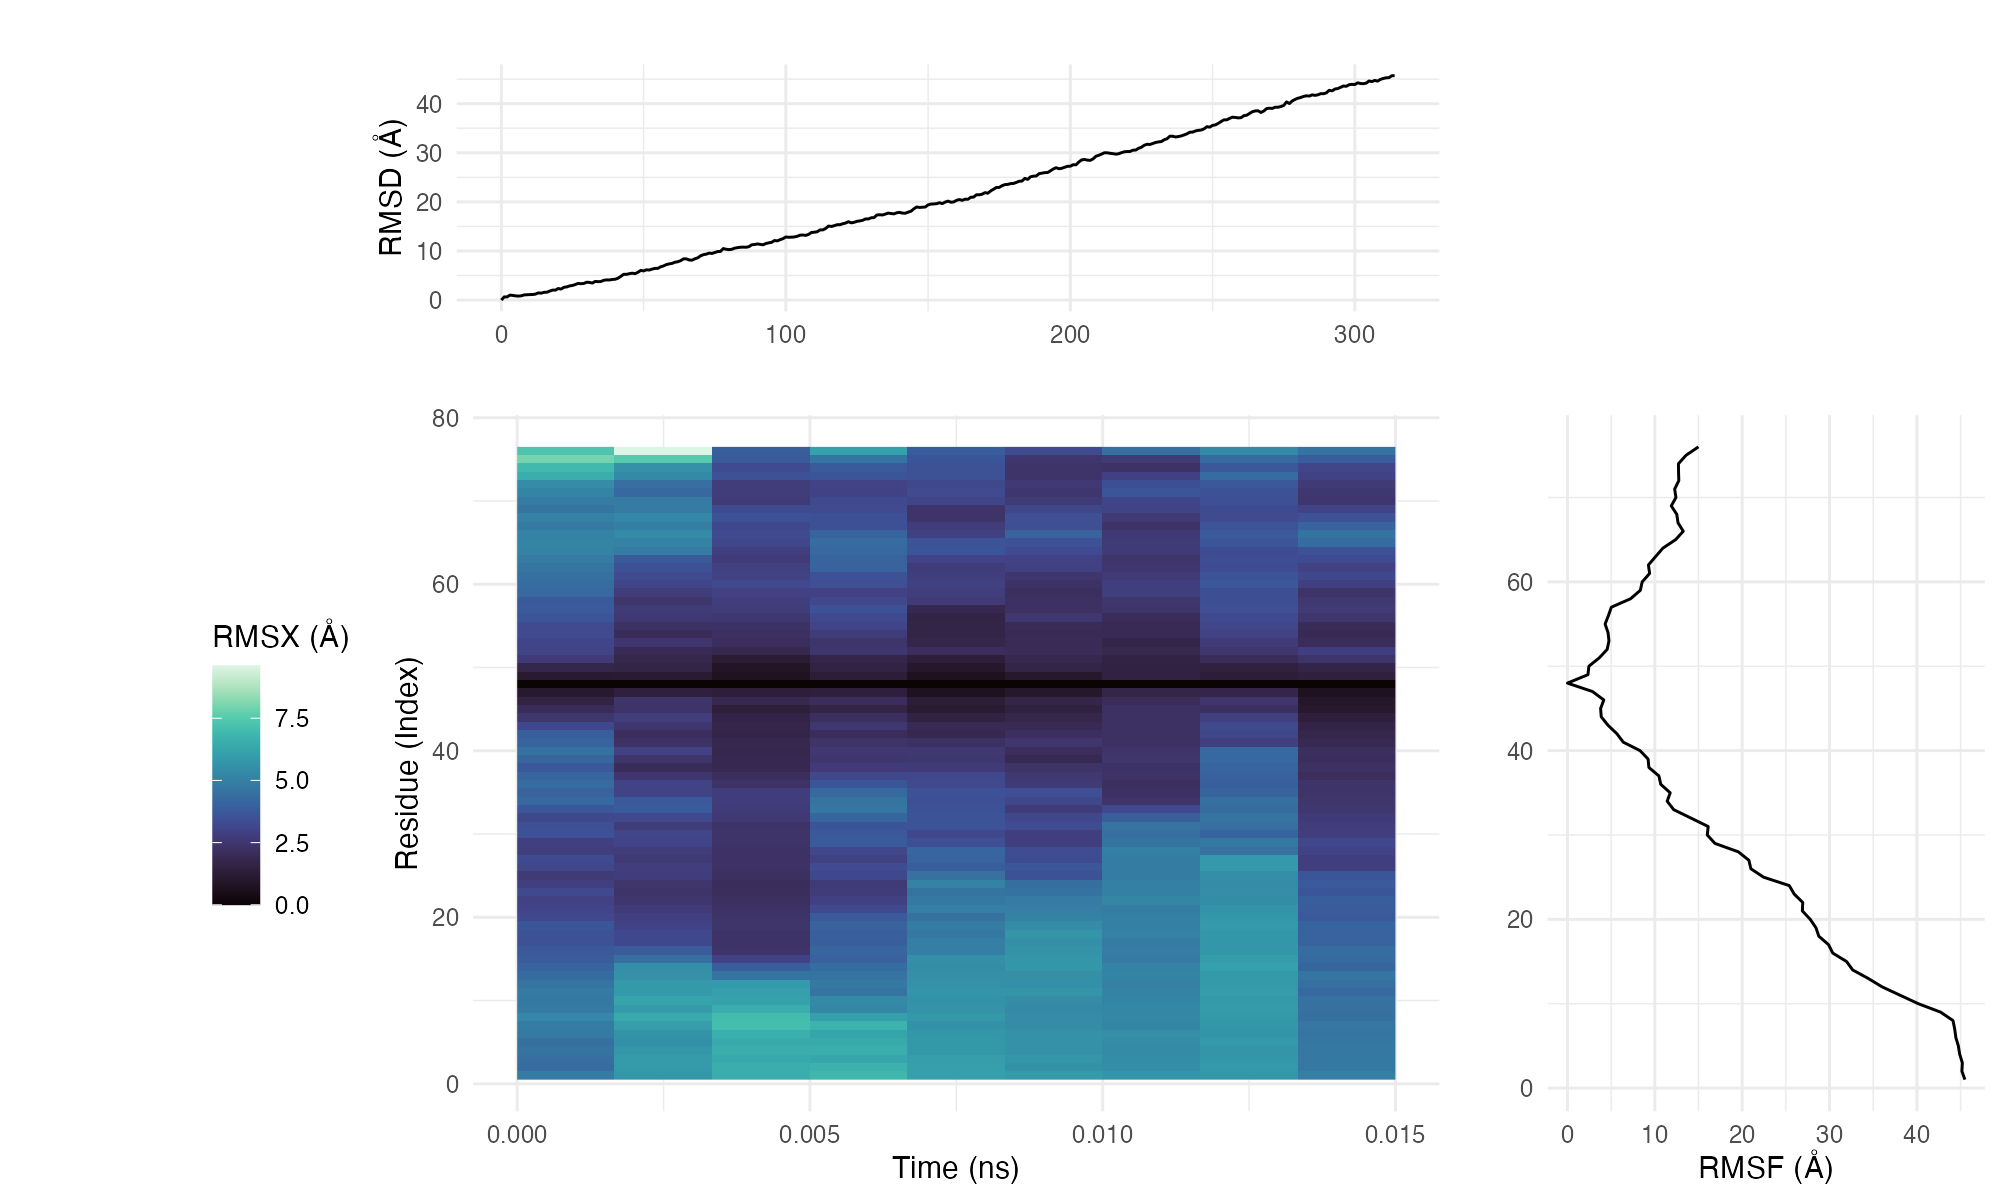


Now summarizing the top 3 and bottom 3 RMSX values...

===== Top 3 RMSX values across all slices =====
TimeSlice: slice_2.dcd, ChainID: 7, ResidueID: 76, RMSX: 9.616
TimeSlice: slice_1.dcd, ChainID: 7, ResidueID: 75, RMSX: 7.957
TimeSlice: slice_2.dcd, ChainID: 7, ResidueID: 75, RMSX: 7.496

===== Bottom 3 RMSX values across all slices =====
TimeSlice: slice_1.dcd, ChainID: 7, ResidueID: 48, RMSX: 0.000
TimeSlice: slice_2.dcd, ChainID: 7, ResidueID: 48, RMSX: 0.000
TimeSlice: slice_3.dcd, ChainID: 7, ResidueID: 48, RMSX: 0.000



(     ResidueID  ChainID    TimeSlice      RMSX
 151         76        7  slice_2.dcd  9.616028
 74          75        7  slice_1.dcd  7.957497
 150         75        7  slice_2.dcd  7.495831,
      ResidueID  ChainID    TimeSlice  RMSX
 47          48        7  slice_1.dcd   0.0
 123         48        7  slice_2.dcd   0.0
 199         48        7  slice_3.dcd   0.0)

In [8]:
from rmsx import *


run_rmsx(
    topology_file=pdb_file,        # PDB or topology file
    trajectory_file=dcd_file,      # Trajectory file
    output_dir=output_dir,         # Where to save results
    num_slices=9,                  # Select number of slices and it will autogenerate slice size 
    slice_size=None,               # OR: select slice size and it will choose number of slices 
    rscript_executable=os.environ.get('RSCRIPT', 'Rscript'),
    verbose=True,                 
    interpolate=False,             # Interpolate between heatmap cells (use with caution)
    triple=True,                   # Generate RMSX, RMSD, and RMSF plots
    overwrite=True,                # Automatically overwrite old directory
    palette="mako",                # Try other colors: viridis, turbo, magma or plasma etc.
    chain_sele="7",                # Set to your chain ID or None to be prompted with available chain 
    start_frame=0,                 # Default to the first frame of the simulation
    end_frame=None                 # Default to None (last frame of simulation)
)


In [9]:
# Troubleshooting: Try this if:
# Not running - make sure everything is installed - close out of notebook, restart and try again

## Can't find the R executable (edits with path to your version of R):
# os.environ["RSCRIPT"] = r"C:\\Program Files\\R\\R-4.4.1\\bin\\Rscript.exe"  # <- edit if needed
## Not finding installing all R packages: 
#!Rscript -e 'user<-Sys.getenv("R_LIBS_USER"); if(user=="") user<-file.path(Sys.getenv("HOME"),"R","library"); dir.create(user,recursive=TRUE,showWarnings=FALSE); .libPaths(c(user,.libPaths())); install.packages(c("ggplot2","viridis","dplyr","tidyr","stringr","readr","gridExtra"), lib=user, dependencies=c("Depends","Imports","LinkingTo"))'
# If you're having trouble with R you can uninstall it and reinstall it - always restart everything for it to take effect.


## 4) Multi-Chain RMSX

`all_chain_rmsx` runs RMSX for **every** chain in the topology. If you set `sync_color_scale=True`,
all plots share a consistent colorbar range. We'll use a protease dimer referenced in our paper as an example. To make it small enough for Github, we'll use a shorter simulation and remove non-backbone atoms for this demo.

/Users/finn/Library/r-miniconda-arm64/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


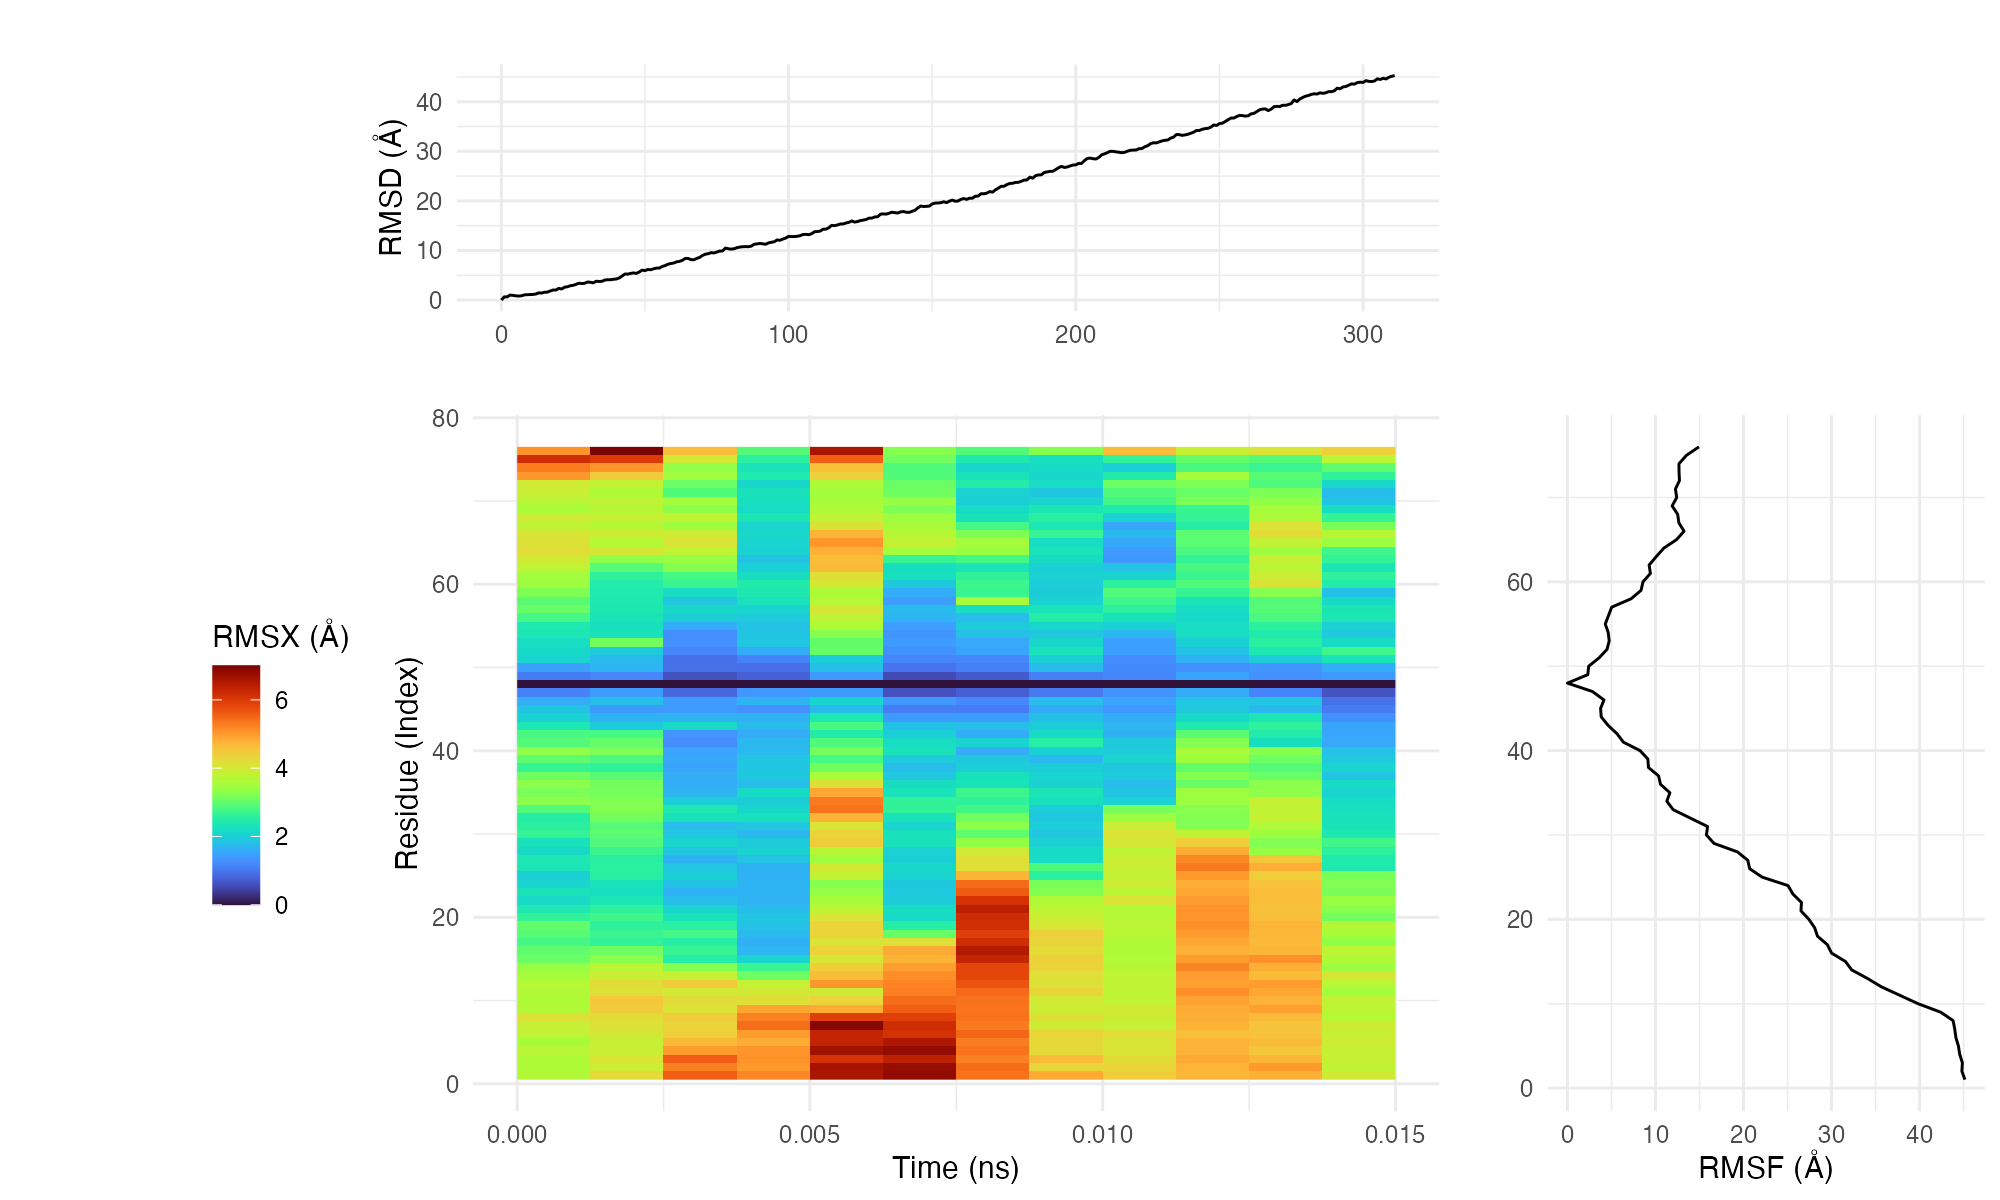

'/Users/finn/Downloads/rmsx/rmsx/test_files/example_uqb/chain_7_rmsx'

In [10]:

all_chain_rmsx(
    topology_file=pdb_file,
    trajectory_file=dcd_file,
    output_dir=output_dir,
    num_slices=12,
    slice_size=None,
    rscript_executable=os.environ.get('RSCRIPT', 'Rscript'),
    verbose=False,
    interpolate=False,
    triple=True,
    overwrite=True,
    palette="turbo",
    start_frame=0,
    end_frame=None,
    sync_color_scale=True           # Useful when chains have very different RMSX values, True will force the same color key/scale to be used
)

## 5) FlipBook (optional)

FlipBook maps RMSX values (stored in the PDB B-factor column) onto 3D structures and lays out snapshots side-by-side.

/Users/finn/Library/r-miniconda-arm64/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/finn/Library/r-miniconda-arm64/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


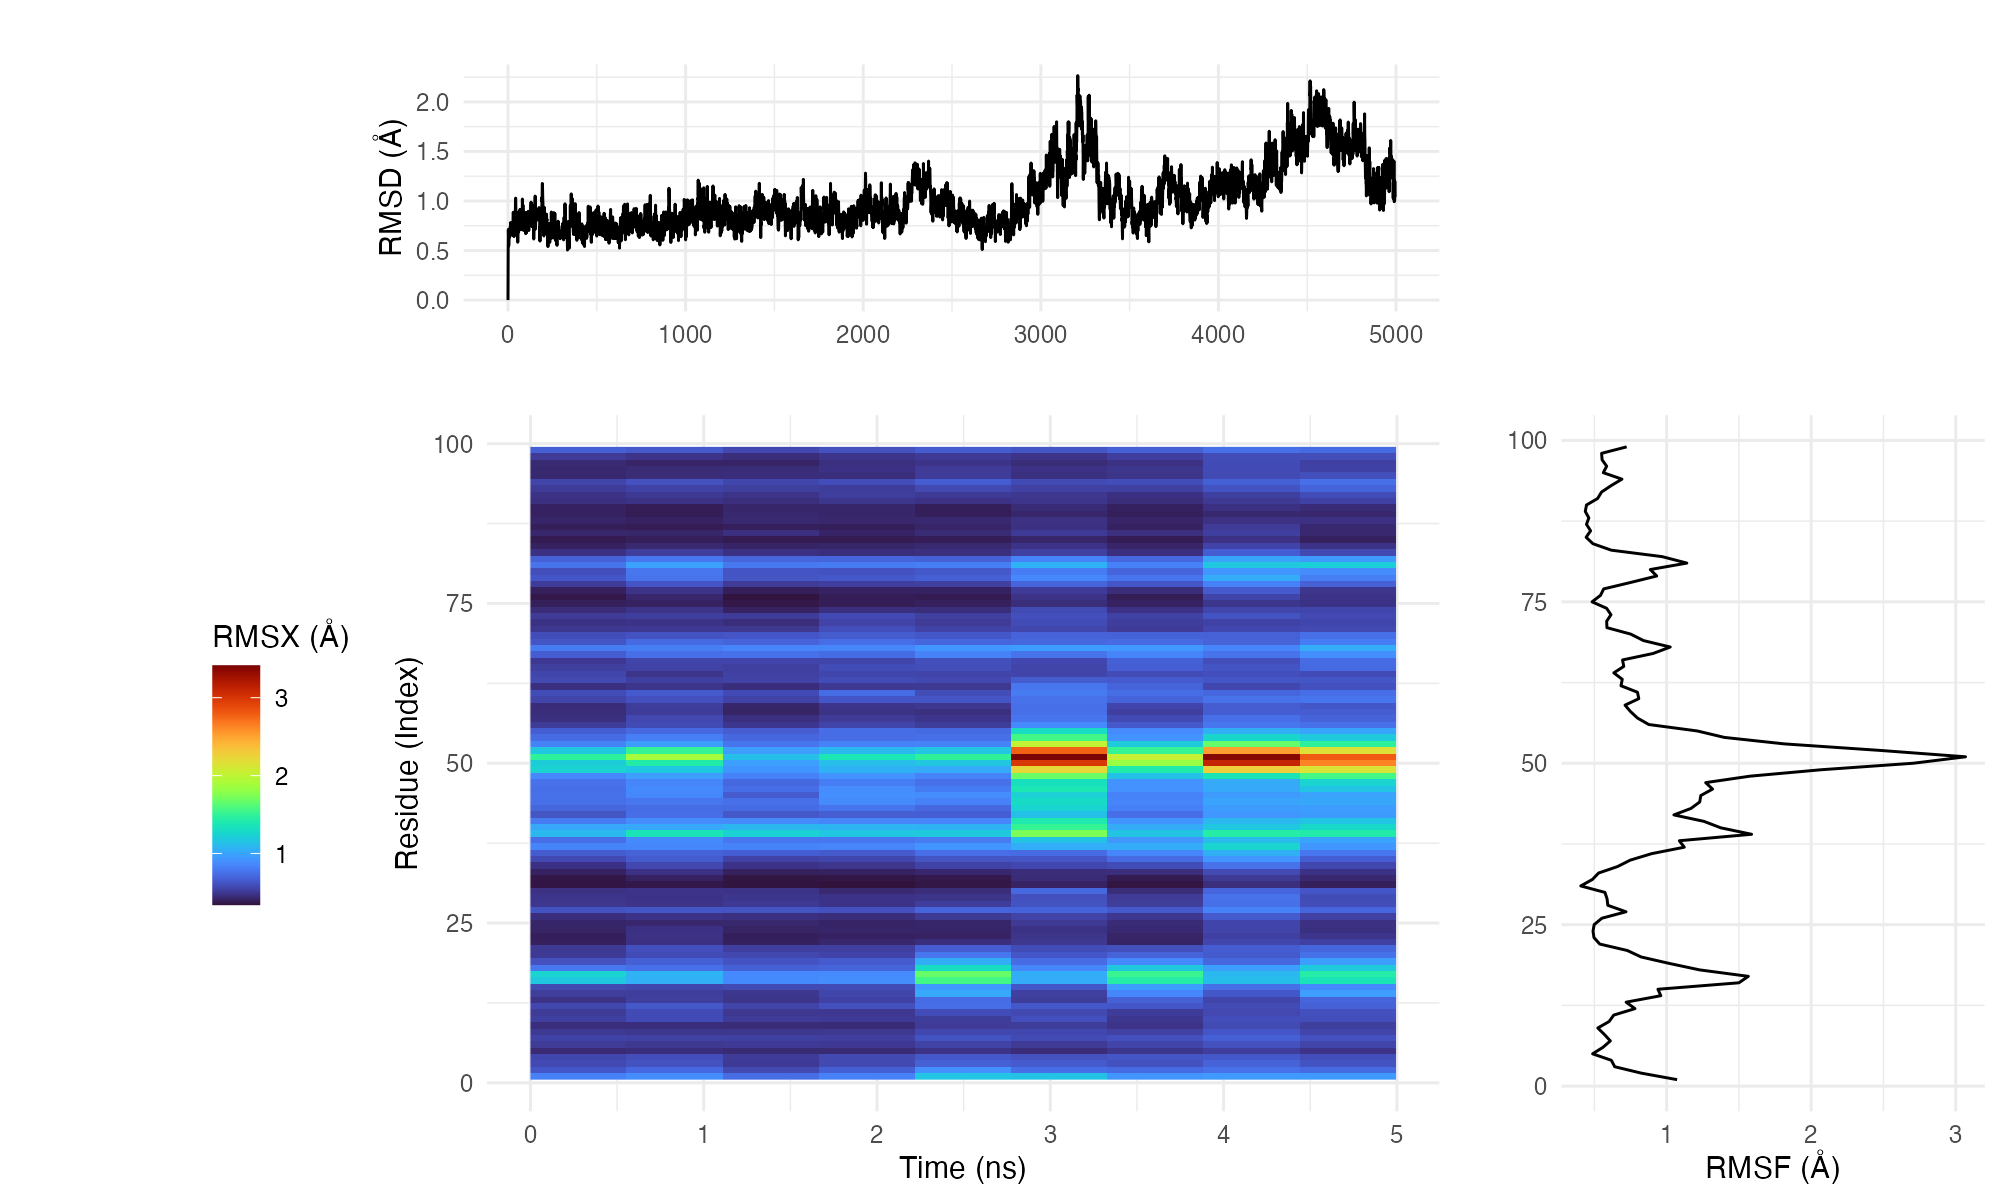

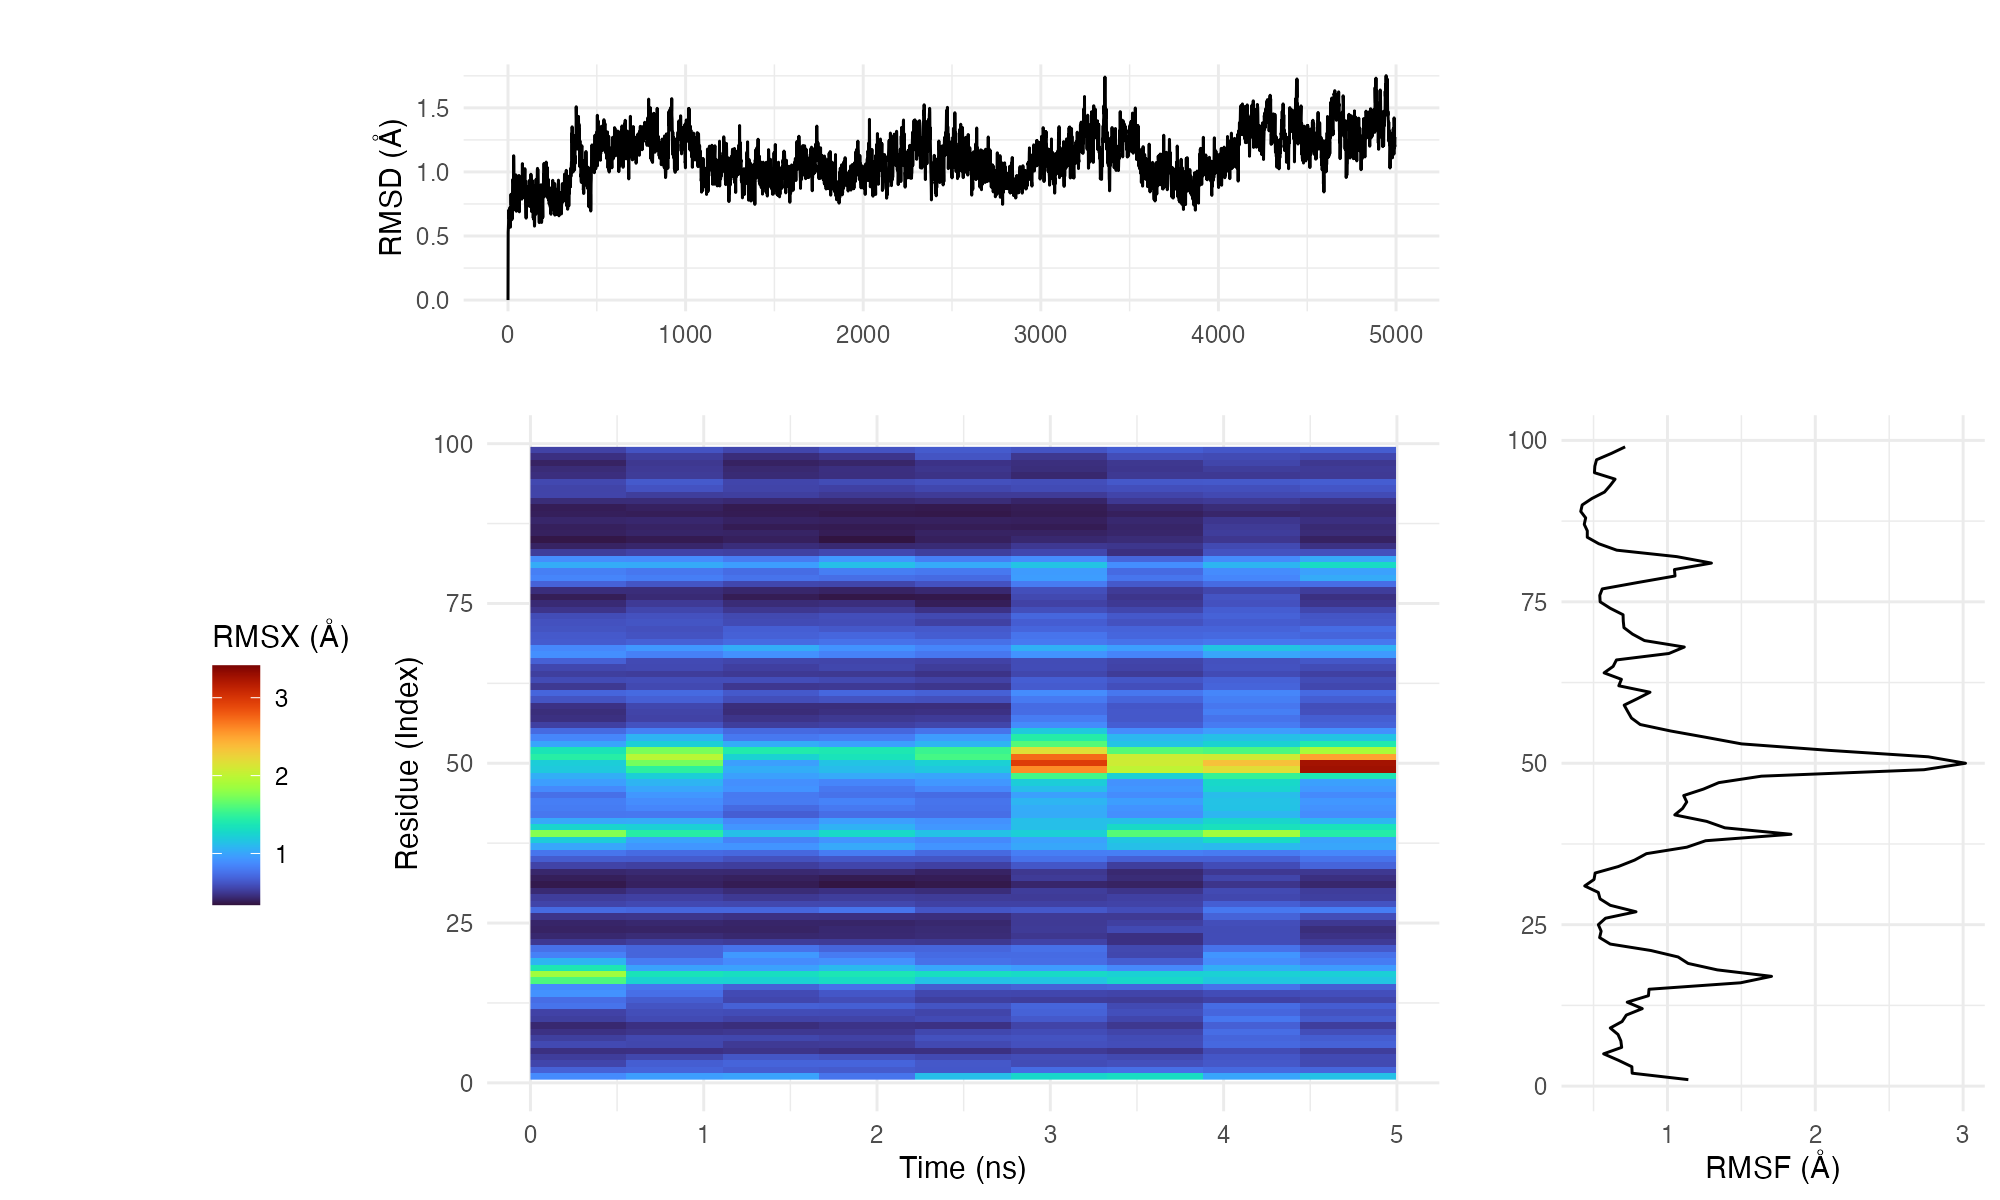

Detected B-factor range: 0.34 - 3.41
[flipbook] macOS bundle candidates (sorted):
   - ChimeraX-1.8.app -> /Applications/ChimeraX-1.8.app/Contents/MacOS/ChimeraX  (ver=1.8, daily=False)
   - ChimeraX-1.5.app -> /Applications/ChimeraX-1.5.app/Contents/MacOS/ChimeraX  (ver=1.5, daily=False)
   - ChimeraX_Daily.app -> /Applications/ChimeraX_Daily.app/Contents/MacOS/ChimeraX  (ver=0, daily=True)
[flipbook] Checking ChimeraX candidates (in order):
   - macOS app bundle (ChimeraX-1.8.app): /Applications/ChimeraX-1.8.app/Contents/MacOS/ChimeraX
[flipbook] Using ChimeraX installation: /Applications/ChimeraX-1.8.app/Contents/MacOS/ChimeraX
[flipbook] Launching: /Applications/ChimeraX-1.8.app/Contents/MacOS/ChimeraX


In [11]:
run_rmsx_flipbook(
    topology_file=pdb_file_multi,
    trajectory_file=traj_file_multi,
    output_dir=output_dir_multi,
    num_slices=9,
    slice_size=None,
    rscript_executable=os.environ.get('RSCRIPT', 'Rscript'),
    verbose=False,
    interpolate=False,
    triple=True,
    overwrite=True,
    palette="turbo",         # automatically matches color palette for heatmap and chimeraX structures 
    spacingFactor="0.9",     # how much space between the snapshots; 1 is default
    start_frame=0,
    end_frame=None
)

### 5.1 Display the latest FlipBook image (if generated)
If you don't like the orientation, try adjusting it in ChimeraX and rerunning the save command (see the ChimeraX log for details)

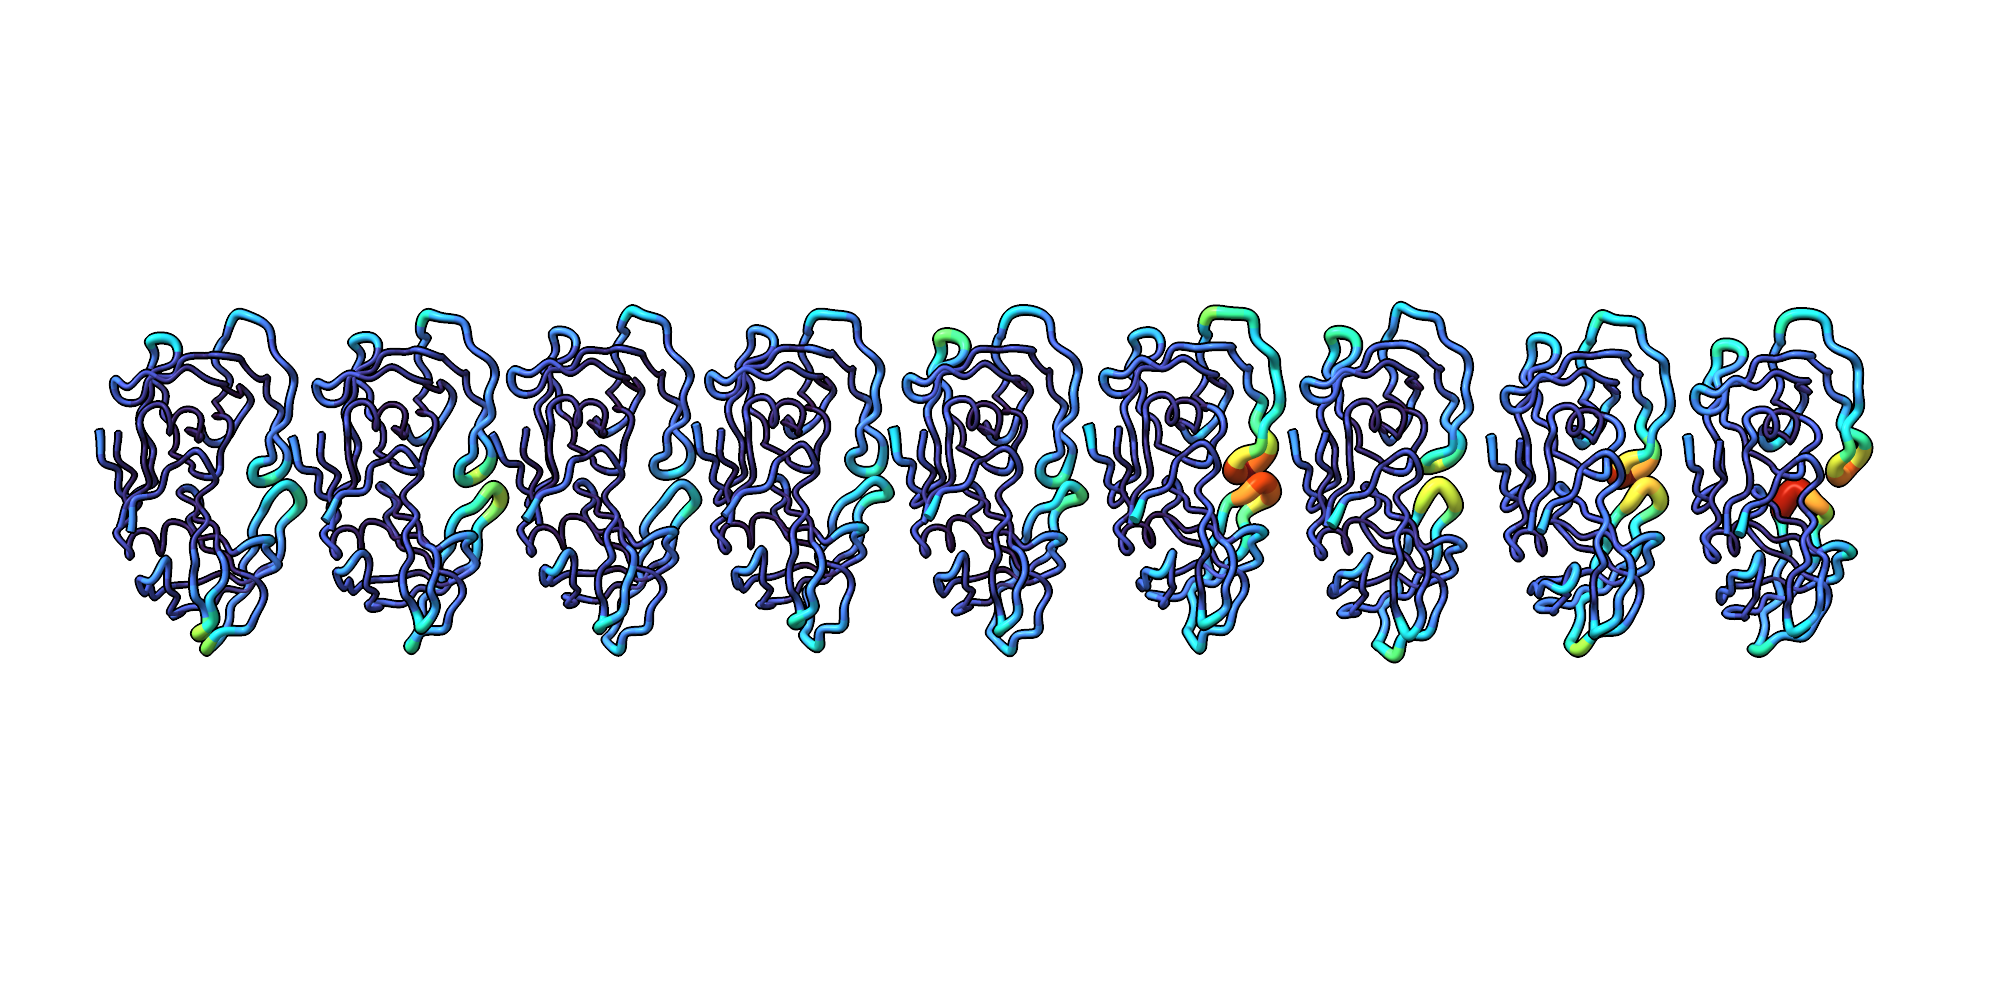

In [12]:
import glob
from IPython.display import Image, display
imgs = sorted(glob.glob(os.path.join(output_dir_multi, "combined", "*.png")))
if imgs:
    display(Image(filename=imgs[-1]))
else:
    print("No flipbook images found in:", os.path.join(output_dir_multi, "combined"))

## 6) Interpreting Results

If you want the flanking plots, `triple=True`, RMSX produces:
- **RMSX heatmap** (residue × time slice)
- **RMSD** over time 
- **RMSF** per residue

**Questions to ask:**
1. Which residues/regions show the most flexibility?
2. When do flexibility spikes occur (early/mid/late)?
3. Do multiple intervals of high fluctuation appear?
4. How do these align with functional domains or events (e.g., binding, domain motion)?

---
### Conclusions

You’ve seen how to:
1. Install and configure **RMSX** and **Flipbook**
2. Run single- and multi-chain analyses
3. Generate FlipBook snapshots (optional)
4. Interpret RMSX plots (when/where the biggest changes happen)

For more details, visit the GitHub repo or open an issue with questions.

Feel free to email the primary developer Finn Beruldsen at fpberuld@cougarnet.uh.edu if you need anything else.


### Acknowledgements
We thank the following beta testers for their valuable feedback on this tutorial:
- Mason Kretiv — Texas A&M University
- Helen Ashdown — NIH Biowulf
- John Miles — University of Missouri